(copied from internet)

In [1]:
import torch
import os
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torchvision.models as models
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
import torchvision.models as models
%matplotlib inline

In [5]:
!git clone https://github.com/Horea94/Fruit-Images-Dataset.git
os.getcwd(),os.listdir('Fruit-Images-Dataset')

Cloning into 'Fruit-Images-Dataset'...
remote: Enumerating objects: 385858, done.
remote: Counting objects: 100% (8693/8693), done.
remote: Compressing objects: 100% (8672/8672), done.
remote: Total 385858 (delta 36), reused 8670 (delta 21), pack-reused 377165
Receiving objects: 100% (385858/385858), 2.10 GiB | 31.50 MiB/s, done.
Resolving deltas: 100% (1196/1196), done.
Checking out files: 100% (90503/90503), done.


('/content',
 ['test-multiple_fruits',
  'src',
  'Test',
  'Training',
  '.git',
  'readme.md',
  'papers',
  'LICENSE'])

In [7]:
path ="/content/Fruit-Images-Dataset/Training"
classes = os.listdir(path)

In [8]:
traning_transforms = transforms.Compose([
    transforms.Resize((100, 100)), 
    transforms.ToTensor()
])

In [10]:
train_dataset = torchvision.datasets.ImageFolder(root=path, transform = traning_transforms)
train_dataset

Dataset ImageFolder
    Number of datapoints: 67692
    Root location: /content/Fruit-Images-Dataset/Training
    StandardTransform
Transform: Compose(
               Resize(size=(100, 100), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
           )

In [11]:
train_loader = torch.utils.data.DataLoader(dataset = train_dataset, batch_size = 32, shuffle = False)

In [12]:
def get_mean_and_std(loader):
    mean = 0
    std = 0
    total_images_count = 0
    for images, _ in loader:
        image_count_in_a_batch = images.size(0)
        images = images.view(image_count_in_a_batch, images.size(1), -1)
        mean += images.mean(2).sum(0)
        std += images.std(2).sum(0)
        total_images_count += image_count_in_a_batch
    mean /= total_images_count
    std /= total_images_count
    return mean, std

In [13]:
mean, std = get_mean_and_std(train_loader)

In [14]:
mean = mean.tolist()

In [15]:
std = std.tolist()

In [16]:
mean, std

([0.6840282678604126, 0.5785940289497375, 0.5037178993225098],
 [0.2585865557193756, 0.32188674807548523, 0.36618027091026306])

In [17]:
train_tranforms = transforms.Compose([
        transforms.Resize((100, 100)),
        transforms.ToTensor(),
        transforms.Normalize(torch.Tensor(mean), torch.Tensor(std))
])
test_tranforms = transforms.Compose([
    transforms.Resize((100, 100)),
    transforms.ToTensor(),
    transforms.Normalize(torch.Tensor(mean), torch.Tensor(std))
])

In [18]:
test_dataset = torchvision.datasets.ImageFolder(root="/content/Fruit-Images-Dataset/Test", transform = test_tranforms)
test_dataset

Dataset ImageFolder
    Number of datapoints: 22688
    Root location: /content/Fruit-Images-Dataset/Test
    StandardTransform
Transform: Compose(
               Resize(size=(100, 100), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
               Normalize(mean=tensor([0.6840, 0.5786, 0.5037]), std=tensor([0.2586, 0.3219, 0.3662]))
           )

In [19]:
def show_transformed_images(dataset):
    loader = torch.utils.data.DataLoader(dataset, batch_size = 6, shuffle=True)
    batch = next(iter(loader))
    images, labels = batch

    grid = torchvision.utils.make_grid(images, nrow = 3)
    plt.figure(figsize=(11,11))
    plt.imshow(np.transpose(grid, (1,2,0)))
    print('labels: ', labels)

labels:  tensor([106,  38,   2,  61,  69, 127])


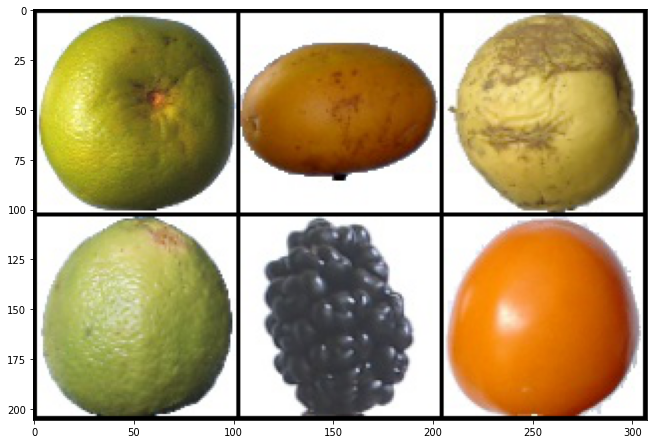

In [20]:
show_transformed_images(train_dataset)

In [21]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = 32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = 32, shuffle=False)

Image Net 18 model

In [22]:
def set_device():
    if torch.cuda.is_available():
        dev = "cuda:0"
    else:
        dev = "cpu"
    return torch.device(dev)

In [23]:
def train_nn(model, train_loader, test_loader, criterion, optimizer, n_epochs):
    device = set_device()
    best_acc = 0

    for epoch in range(n_epochs):
        print("Epoch Number: ", epoch + 1)
        model.train()
        running_loss = 0.0
        running_correct = 0.0
        total = 0

        for data in train_loader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            
            total += labels.size(0)

            optimizer.zero_grad()

            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)

            loss = criterion(outputs, labels)

            loss.backward()

            optimizer.step()

            running_loss += loss.item()

            running_correct += (labels==predicted).sum().item()

        epoch_loss = running_loss/len(train_loader)

        epoch_acc = 100*running_correct/total

        print("Got", running_correct, "images correct out of", total, "epoch_acc=", epoch_acc, "epoch_loss=", epoch_loss)

        test_data_acc = evaluvate_model_on_test_Set(model, test_loader)

        if (test_data_acc > best_acc):
            best_acc = test_data_acc
            save_checkpoint(model, epoch, optimizer, best_acc)



    print("Finished")
    return model

In [24]:
def evaluvate_model_on_test_Set(model, test_loader):
    model.eval()
    predicted_correctly_on_epoch =  0
    total = 0    
    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            total += labels.size(0)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)

            predicted_correctly_on_epoch += (predicted == labels).sum().item()
        
        acc = 1000*predicted_correctly_on_epoch/total
        print(predicted_correctly_on_epoch,"Images were correctly classified out of", total, "accuracy=", acc)
        return acc

In [25]:
def save_checkpoint(model, epoch, optimizer, best_acc):
    state = {
        'epoch':epoch+1,
        'model': model.state_dict(),
        'best_accuracy': best_acc,
        'optimizer': optimizer.state_dict() 
    }
    torch.save(state, 'model_best_checkpoint.pth.tar')

In [26]:
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
resnet18_model = models.resnet18(pretrained = False)
num_ftrs = resnet18_model.fc.in_features
number_of_classes = 131
resnet18_model.fc = nn.Linear(num_ftrs, number_of_classes)
device = set_device()
resnet_18_model = resnet18_model.to(device)
loss_fn = nn.CrossEntropyLoss()

optimizer = optim.SGD(resnet_18_model.parameters(), lr=0.1, momentum=0.9, weight_decay=0.003)
# Stocastic Gradient Decest

In [ ]:
model = train_nn(resnet18_model, train_loader, test_loader, loss_fn, optimizer, 50)

Epoch Number:  1
Got 43344.0 images correct out of 67692 epoch_acc= 64.03120014181883 epoch_loss= 1.271799900708104
142 Images were correctly classified out of 22688 accuracy= 6.258815232722144
Epoch Number:  2


In [ ]:
image_tranforms = transforms.Compose([
    transforms.Resize((100, 100)),
    transforms.ToTensor(),
    transforms.Normalize(torch.Tensor(mean), torch.Tensor(std))
])

In [ ]:
from PIL import Image

In [ ]:
def classify(model, image_transforms, image_path, classes):
    model = model.eval()
    image = Image.open("Test/Apricot/321_100.jpg")
    image = image_transforms(image).float()
    image = image.unsquuze(0)
    output = model(image)
    _, predicted = torch.max(output.data, 1)
    print(predicted)
    # print(classes[predicted.item()])
    

In [ ]:
classify(model, image_tranforms, "", ["Apricot, Apple"])